In [17]:
import clip
from PIL import Image
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from lpips import LPIPS
import os
import matplotlib.pyplot as plt
import torch
# Load CLIP model and preprocessing pipeline
lpips_model = LPIPS(net='alex')  # AlexNet backbone for LPIPS

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# Define the upscaling function
def upscale_image_bicubic(image, scale):
    height, width = image.shape[:2]
    new_height, new_width = height * scale, width * scale
    upscaled_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
    return upscaled_image

# Define the metrics calculation function
def calculate_metrics(high_res, generated, lpips_model, clip_model, clip_preprocess, win_size=3):
    psnr_value = psnr(high_res, generated, data_range=generated.max() - generated.min())
    ssim_value = ssim(
        high_res, 
        generated, 
        multichannel=True, 
        data_range=generated.max() - generated.min(), 
        win_size=win_size
    )

    # Convert images to tensors for LPIPS
    high_res_tensor = torch.from_numpy(high_res).permute(2, 0, 1).float() / 255.0
    generated_tensor = torch.from_numpy(generated).permute(2, 0, 1).float() / 255.0

    # LPIPS (Lower is better)
    lpips_value = lpips_model(high_res_tensor.unsqueeze(0), generated_tensor.unsqueeze(0)).item()

    # Convert images to PIL and preprocess for CLIP
    high_res_pil = Image.fromarray(high_res)
    generated_pil = Image.fromarray(generated)

    high_res_clip = clip_preprocess(high_res_pil).unsqueeze(0).to(device)
    generated_clip = clip_preprocess(generated_pil).unsqueeze(0).to(device)

    # Extract features with CLIP
    with torch.no_grad():
        high_res_features = clip_model.encode_image(high_res_clip)
        generated_features = clip_model.encode_image(generated_clip)

    # CLIP similarity score (cosine similarity)
    clip_score = torch.cosine_similarity(high_res_features, generated_features).item()

    return psnr_value, ssim_value, lpips_value, clip_score

# Update the loop in `process_images_with_metrics` to include CLIP metrics
def process_images_with_metrics(low_res_dir, high_res_dir, scale=4):
    results = []  # Store results for visualization

    low_res_files = sorted(os.listdir(low_res_dir))

    # Cumulative metrics for averaging
    total_psnr, total_ssim, total_lpips, total_clip = 0, 0, 0, 0
    count = 0

    for low_res_file in low_res_files:
        # Construct file paths
        low_res_path = os.path.join(low_res_dir, low_res_file)
        high_res_path = os.path.join(high_res_dir, low_res_file)  # Matching by name

        # Check if the corresponding high-res image exists
        if not os.path.exists(high_res_path):
            print(f"High-res file not found for {low_res_file}. Skipping...")
            continue

        # Load images
        low_res_image = cv2.imread(low_res_path)
        high_res_image = cv2.imread(high_res_path)

        if low_res_image is None or high_res_image is None:
            print(f"Error: Couldn't load {low_res_path} or {high_res_path}. Skipping...")
            continue

        # Convert images to RGB
        low_res_image = cv2.cvtColor(low_res_image, cv2.COLOR_BGR2RGB)
        high_res_image = cv2.cvtColor(high_res_image, cv2.COLOR_BGR2RGB)

        # Upscale the low-resolution image
        upscaled_image = upscale_image_bicubic(low_res_image, scale=scale)

        # Ensure both images are the same size for metric computation
        height, width = high_res_image.shape[:2]
        upscaled_image = cv2.resize(upscaled_image, (width, height), interpolation=cv2.INTER_CUBIC)

        # Calculate PSNR, SSIM, LPIPS, and CLIP
        psnr_value, ssim_value, lpips_value, clip_score = calculate_metrics(
            high_res_image, upscaled_image, lpips_model, clip_model, clip_preprocess, win_size=3
        )

        # Update cumulative metrics
        total_psnr += psnr_value
        total_ssim += ssim_value
        total_lpips += lpips_value
        total_clip += clip_score
        count += 1

        # Append results for later visualization
        results.append((low_res_file, low_res_image, high_res_image, upscaled_image, psnr_value, ssim_value, lpips_value, clip_score))

        print(f"Processed {low_res_file}: PSNR={psnr_value:.2f}, SSIM={ssim_value:.4f}, LPIPS={lpips_value:.4f}, CLIP Score={clip_score:.4f}")

    # Calculate averages
    avg_psnr = total_psnr / count if count > 0 else 0
    avg_ssim = total_ssim / count if count > 0 else 0
    avg_lpips = total_lpips / count if count > 0 else 0
    avg_clip = total_clip / count if count > 0 else 0

    print(f"\nAverage PSNR: {avg_psnr:.2f} dB")
    print(f"Average SSIM: {avg_ssim:.4f}")
    print(f"Average LPIPS: {avg_lpips:.4f} (lower is better)")
    print(f"Average CLIP Score: {avg_clip:.4f} (higher is better)")

    return results

# Set directories for low-res and high-res images
low_res_dir = "flask/static/images/selected_256"  # Directory for low-resolution images
high_res_dir = "dataset/DIV/final/high"          # Directory for high-resolution images


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/hamzaz/miniconda3/envs/apw/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


In [18]:
# Process images and visualize
results = process_images_with_metrics(low_res_dir, high_res_dir, scale=4)


Processed 0801.png: PSNR=23.68, SSIM=0.6471, LPIPS=0.4513, CLIP Score=0.9697
Processed 0802.png: PSNR=27.95, SSIM=0.9569, LPIPS=0.2529, CLIP Score=0.9541
Processed 0806.png: PSNR=24.40, SSIM=0.8543, LPIPS=0.3105, CLIP Score=0.9683
Processed 0809.png: PSNR=26.15, SSIM=0.8636, LPIPS=0.3946, CLIP Score=0.9785
Processed 0814.png: PSNR=24.35, SSIM=0.8824, LPIPS=0.2280, CLIP Score=0.9858
Processed 0816.png: PSNR=27.31, SSIM=0.8410, LPIPS=0.3905, CLIP Score=0.9785
Processed 0819.png: PSNR=23.71, SSIM=0.7372, LPIPS=0.4589, CLIP Score=0.9731
Processed 0821.png: PSNR=18.71, SSIM=0.7055, LPIPS=0.3231, CLIP Score=0.9736
Processed 0824.png: PSNR=22.90, SSIM=0.8474, LPIPS=0.3185, CLIP Score=0.9785
Processed 0825.png: PSNR=21.44, SSIM=0.7715, LPIPS=0.4869, CLIP Score=0.9697
Processed 0829.png: PSNR=26.36, SSIM=0.9294, LPIPS=0.3425, CLIP Score=0.9795
Processed 0831.png: PSNR=23.62, SSIM=0.8183, LPIPS=0.4468, CLIP Score=0.9766
Processed 0834.png: PSNR=23.37, SSIM=0.8067, LPIPS=0.3740, CLIP Score=0.9795

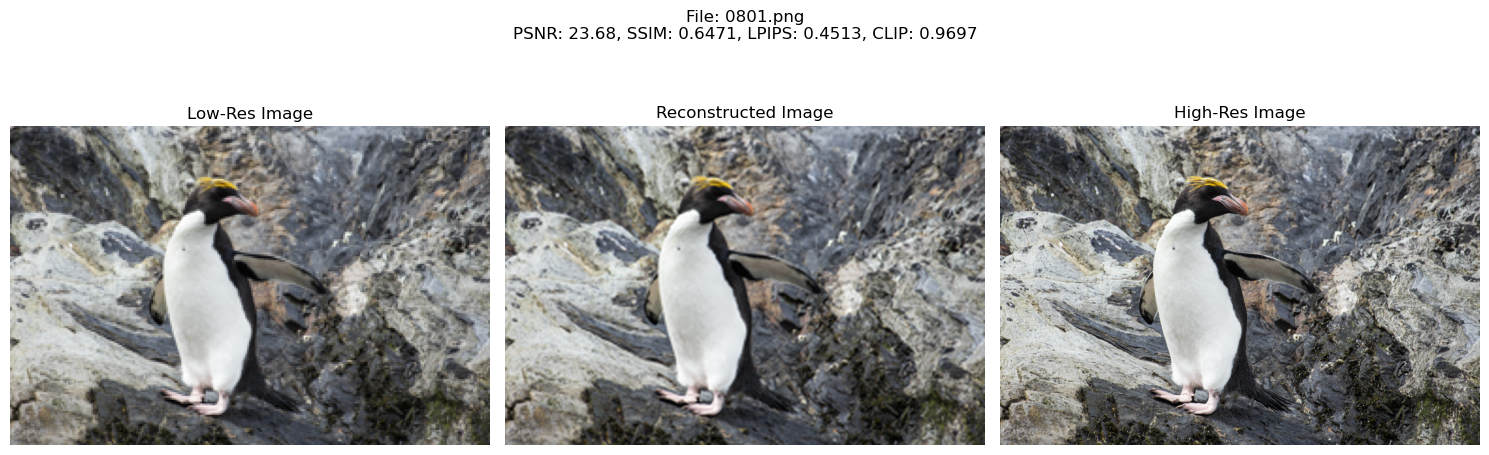

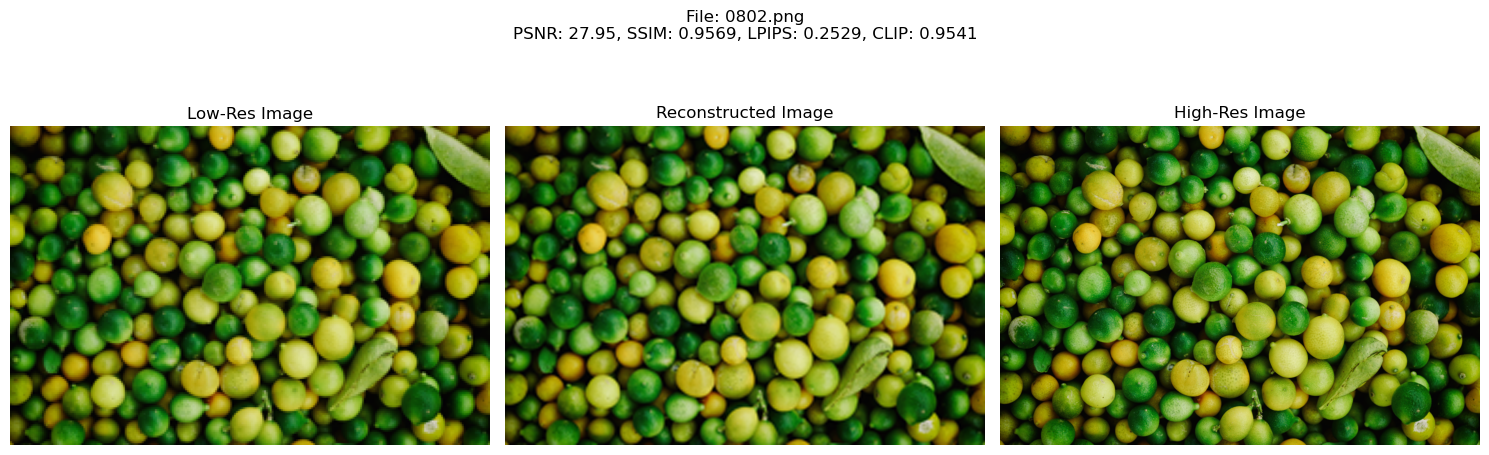

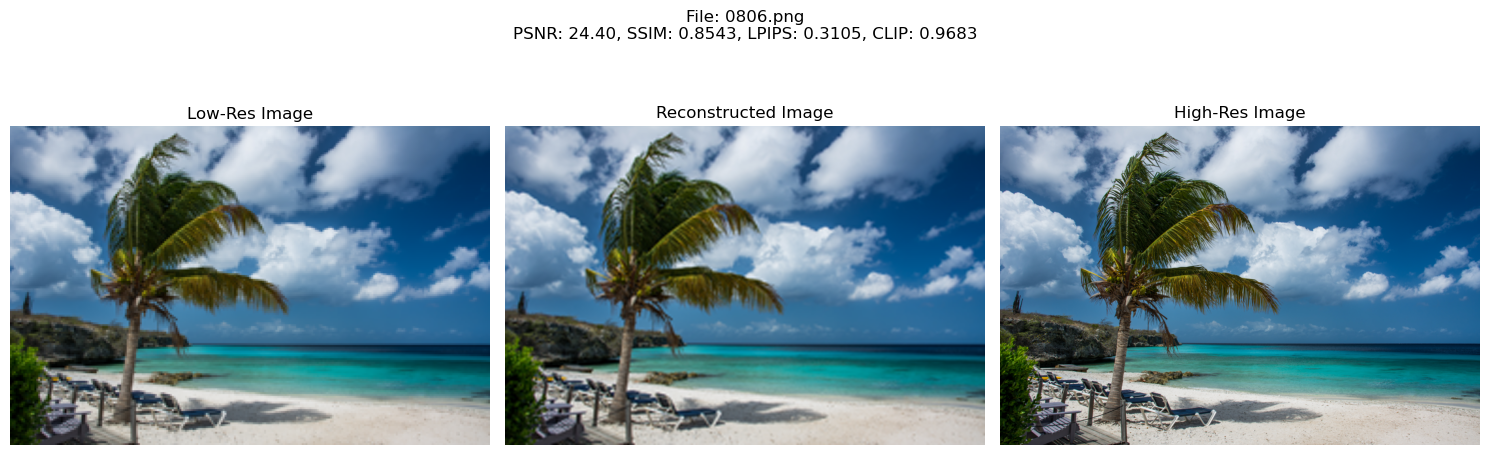

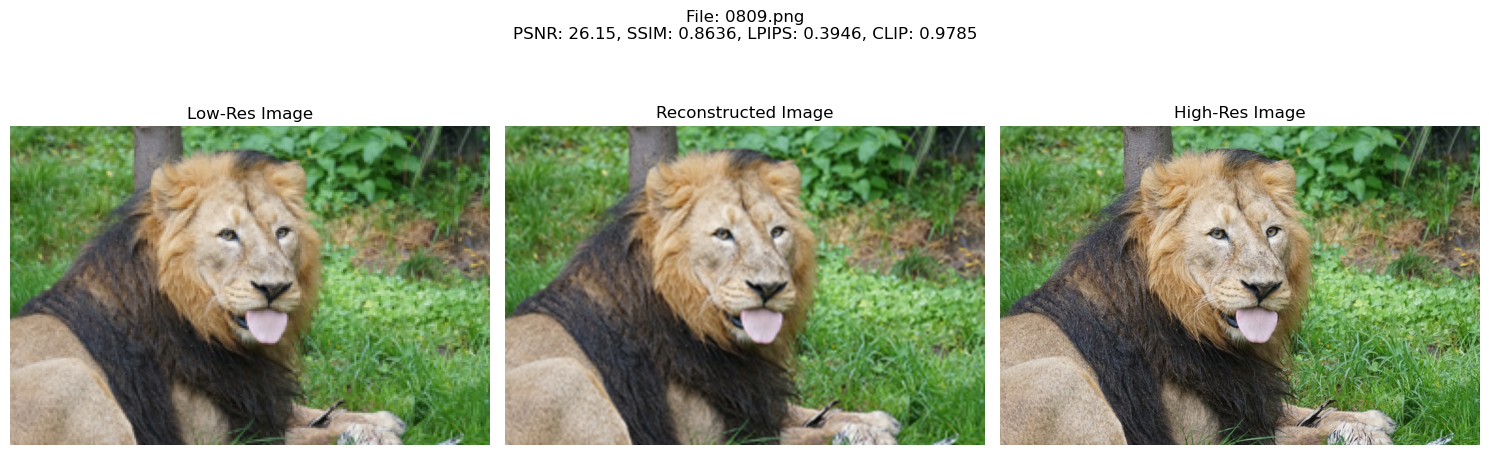

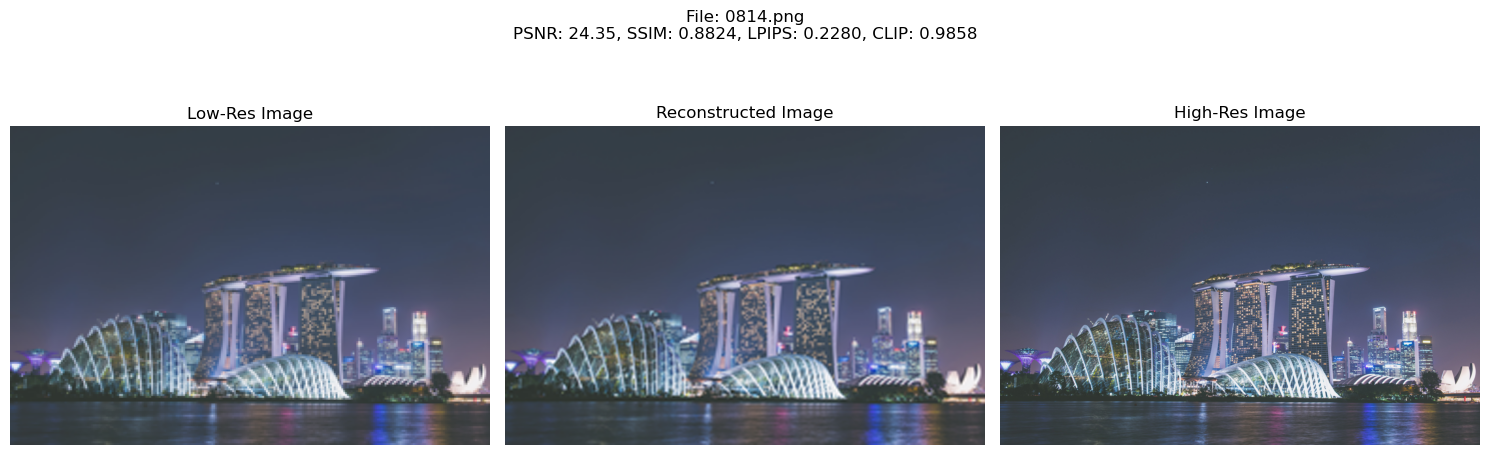

In [19]:
import matplotlib.pyplot as plt

def visualize_results_interactive(results, num_samples=5):
    """
    Visualize low-res, reconstructed, and high-res images with their metrics interactively.
    
    Parameters:
        results (list): List of tuples containing file name, low-res, high-res, upscaled images, and metrics.
        num_samples (int): Number of samples to visualize.
    """
    # Shuffle results to display diverse samples
    selected_results = results[:num_samples]

    for filename, low_res_image, high_res_image, upscaled_image, psnr_value, ssim_value, lpips_value, clip_score in selected_results:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f"File: {filename}\n"
                     f"PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, LPIPS: {lpips_value:.4f}, CLIP: {clip_score:.4f}", 
                     fontsize=12)

        # Low-resolution image
        axes[0].imshow(low_res_image)
        axes[0].axis('off')
        axes[0].set_title("Low-Res Image")

        # Reconstructed image (upscaled)
        axes[1].imshow(upscaled_image)
        axes[1].axis('off')
        axes[1].set_title("Reconstructed Image")

        # High-resolution image
        axes[2].imshow(high_res_image)
        axes[2].axis('off')
        axes[2].set_title("High-Res Image")

        # Show the figure
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

# Call the interactive visualization function
visualize_results_interactive(results, num_samples=5)
